#### IMPORT LIBRARY

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.graph_objs as go
import plotly.plotly as py
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

import category_encoders as ce
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,RobustScaler
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score,matthews_corrcoef,roc_auc_score

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from xgboost import XGBRegressor,XGBClassifier

from imblearn.over_sampling import RandomOverSampler

#### READ DATA

In [24]:
df_bank=pd.read_csv("datasets\Bank Loan Prediction.csv")
df_bank.head()

Loan ID                           Customer ID  \
0  14dd8831-6af5-400b-83ec-68e61888a048  981165ec-3274-42f5-a3b4-d104041a9ca9   
1  4771cc26-131a-45db-b5aa-537ea4ba5342  2de017a3-2e01-49cb-a581-08169e83be29   
2  4eed4e6a-aa2f-4c91-8651-ce984ee8fb26  5efb2b2b-bf11-4dfd-a572-3761a2694725   
3  77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a  e777faab-98ae-45af-9a86-7ce5b33b1011   
4  d4062e70-befa-4995-8643-a0de73938182  81536ad9-5ccf-4eb8-befb-47a4d608658e   

  Loan Status  Current Loan Amount        Term  Credit Score  Annual Income  \
0  Fully Paid             445412.0  Short Term         709.0      1167493.0   
1  Fully Paid             262328.0  Short Term           NaN            NaN   
2  Fully Paid           99999999.0  Short Term         741.0      2231892.0   
3  Fully Paid             347666.0   Long Term         721.0       806949.0   
4  Fully Paid             176220.0  Short Term           NaN            NaN   

  Years in current job Home Ownership             Purpose  Monthly Debt  \
0              8 years  Home Mortgage   Home Improvements       5214.74   
1            10+ years  Home Mortgage  Debt Consolidation      33295.98   
2              8 years       Own Home  Debt Consolidation      29200.53   
3              3 years       Own Home  Debt Consolidation       8741.90   
4              5 years           Rent  Debt Consolidation      20639.70   

   Years of Credit History  Months since last delinquent  \
0                     17.2                           NaN   
1                     21.1                           8.0   
2                     14.9                          29.0   
3                     12.0                           NaN   
4                      6.1                           NaN   

   Number of Open Accounts  Number of Credit Problems  Current Credit Balance  \
0                      6.0                        1.0                228190.0   
1                     35.0                        0.0                229976.0   
2                     18.0                        1.0                297996.0   
3                      9.0                        0.0                256329.0   
4                     15.0                        0.0                253460.0   

   Maximum Open Credit  Bankruptcies  Tax Liens  
0             416746.0           1.0        0.0  
1             850784.0           0.0        0.0  
2             750090.0           0.0        0.0  
3             386958.0           0.0        0.0  
4             427174.0           0.0        0.0

#### DATA OVERVIEW

In [4]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
Loan ID                         100000 non-null object
Customer ID                     100000 non-null object
Loan Status                     100000 non-null object
Current Loan Amount             100000 non-null float64
Term                            100000 non-null object
Credit Score                    80846 non-null float64
Annual Income                   80846 non-null float64
Years in current job            95778 non-null object
Home Ownership                  100000 non-null object
Purpose                         100000 non-null object
Monthly Debt                    100000 non-null float64
Years of Credit History         100000 non-null float64
Months since last delinquent    46859 non-null float64
Number of Open Accounts         100000 non-null float64
Number of Credit Problems       100000 non-null float64
Current Credit Balance          100000 non-null float64
Maxi

In [5]:
view_data=df_bank.copy()
df_overview=pd.DataFrame(columns=['dataFeatures','dataType','null','nullPct','unique','uniqueSample'],
             data=[[kolom,
                    view_data[kolom].dtype,
                    sum(view_data[kolom].isnull()),
                    sum(view_data[kolom].isnull())/len(view_data)*100,
                    view_data[kolom].nunique(),
                    list(view_data[kolom].sample(5).drop_duplicates().values)
             ]for kolom in view_data.columns]
            )
del view_data
df_overview

dataFeatures dataType   null    nullPct  unique  \
0                        Loan ID   object    514   0.511372   81999   
1                    Customer ID   object    514   0.511372   81999   
2                    Loan Status   object    514   0.511372       2   
3            Current Loan Amount  float64    514   0.511372   22004   
4                           Term   object    514   0.511372       2   
5                   Credit Score  float64  19668  19.567423     324   
6                  Annual Income  float64  19668  19.567423   36174   
7           Years in current job   object   4736   4.711781      11   
8                 Home Ownership   object    514   0.511372       4   
9                        Purpose   object    514   0.511372      16   
10                  Monthly Debt  float64    514   0.511372   65765   
11       Years of Credit History  float64    514   0.511372     506   
12  Months since last delinquent  float64  53655  53.380624     116   
13       Number of Open Accounts  float64    514   0.511372      51   
14     Number of Credit Problems  float64    514   0.511372      14   
15        Current Credit Balance  float64    514   0.511372   32730   
16           Maximum Open Credit  float64    516   0.513361   44596   
17                  Bankruptcies  float64    718   0.714328       8   
18                     Tax Liens  float64    524   0.521320      12   

                                         uniqueSample  
0   [0004f37b-5859-40f6-98d0-367aa3b3f3f1, 3732063...  
1   [994b52d4-ab72-467e-99f2-66d8ee744d99, cf0eac2...  
2                                        [Fully Paid]  
3   [60434.0, 223960.0, 178508.0, 193644.0, 426602.0]  
4                             [Long Term, Short Term]  
5                  [nan, 7380.0, 648.0, 713.0, 646.0]  
6               [1286186.0, nan, 1141368.0, 985834.0]  
7             [10+ years, 6 years, < 1 year, 7 years]  
8                               [Rent, Home Mortgage]  
9                                [Debt Consolidation]  
10   [15033.75, 13431.1, 10320.42, 14692.13, 7565.99]  
11                     [15.4, 22.0, 12.6, 22.8, 17.9]  
12                            [25.0, nan, 10.0, 65.0]  
13                     [14.0, 17.0, 18.0, 13.0, 10.0]  
14                                              [0.0]  
15       [0.0, 206663.0, 473613.0, 192014.0, 62282.0]  
16  [1203466.0, 1259368.0, 666974.0, 503426.0, 616...  
17                                              [0.0]  
18                                              [0.0]

#### FILLING MISSING DATA

In [6]:
df_bank=df_bank.dropna(thresh=2)

In [7]:
temp_df=df_bank.groupby(['Loan Status','Term','Years in current job','Home Ownership'],as_index=False).mean().round().copy()
def isi_nan(myrow,kolom):
    return temp_df[(temp_df['Loan Status']==myrow['Loan Status'])
                  &(temp_df['Term']==myrow['Term'])
                  &(temp_df['Years in current job']==myrow['Years in current job'])
                  &(temp_df['Home Ownership']==myrow['Home Ownership'])
                  ][kolom].max()

df_bank['Credit Score'].fillna(df_bank.apply(lambda x : isi_nan(x,'Credit Score'),axis=1),inplace=True)
df_bank['Annual Income'].fillna(df_bank.apply(lambda x : isi_nan(x,'Annual Income'),axis=1),inplace=True)
df_bank['Bankruptcies'].fillna(df_bank.apply(lambda x : isi_nan(x,'Bankruptcies'),axis=1),inplace=True)
df_bank['Maximum Open Credit'].fillna(df_bank.apply(lambda x : isi_nan(x,'Maximum Open Credit'),axis=1),inplace=True)
df_bank['Tax Liens'].fillna(df_bank.apply(lambda x : isi_nan(x,'Tax Liens'),axis=1),inplace=True)
del temp_df

In [8]:
df_bank=df_bank[df_bank.isnull().sum(axis=1)<3]

In [9]:
temp_df=df_bank[df_bank.isnull().sum(axis=1)<1].copy()

def isi_nan2(myrow,kolom):
    temp=temp_df[(temp_df['Loan Status']==myrow['Loan Status'])
                  &(temp_df['Term']==myrow['Term'])
                  &(temp_df['Home Ownership']==myrow['Home Ownership'])
                  &(temp_df['Purpose']==myrow['Purpose'])
                  &(temp_df['Number of Open Accounts']==myrow['Number of Open Accounts'])
                  &(temp_df['Number of Credit Problems']==myrow['Number of Credit Problems'])
                  &(temp_df['Bankruptcies']==myrow['Bankruptcies'])
                  ][kolom]#.value_counts().index[0]
    if len(temp)>0: return temp.value_counts().index[0]
    elif len(temp)==0: return '-1'
  

df_bank['Years in current job'].fillna(df_bank.apply(lambda x : isi_nan2(x,'Years in current job'),axis=1),inplace=True)

In [10]:
df_bank=df_bank[df_bank['Years in current job']!='-1']

In [11]:
df_bank=df_bank.drop('Months since last delinquent',axis=1)

In [29]:
df_bank['Purpose'][df_bank['Purpose']=='other']='Other'
df_bank['Purpose'][df_bank['Purpose']=='Take a Trip']='vacation'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [12]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98934 entries, 0 to 99998
Data columns (total 18 columns):
Loan ID                      98934 non-null object
Customer ID                  98934 non-null object
Loan Status                  98934 non-null object
Current Loan Amount          98934 non-null float64
Term                         98934 non-null object
Credit Score                 98934 non-null float64
Annual Income                98934 non-null float64
Years in current job         98934 non-null object
Home Ownership               98934 non-null object
Purpose                      98934 non-null object
Monthly Debt                 98934 non-null float64
Years of Credit History      98934 non-null float64
Number of Open Accounts      98934 non-null float64
Number of Credit Problems    98934 non-null float64
Current Credit Balance       98934 non-null float64
Maximum Open Credit          98934 non-null float64
Bankruptcies                 98934 non-null float64
Tax Liens     

In [30]:
df_bank.to_csv('datasets/Bank Loan Prediction_NANFREE.csv',index=False)

In [27]:
df_bank=pd.read_csv('datasets/Bank Loan Prediction_NANFREE v2.csv')

#### EDA

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



<Figure size 1440x1440 with 0 Axes>

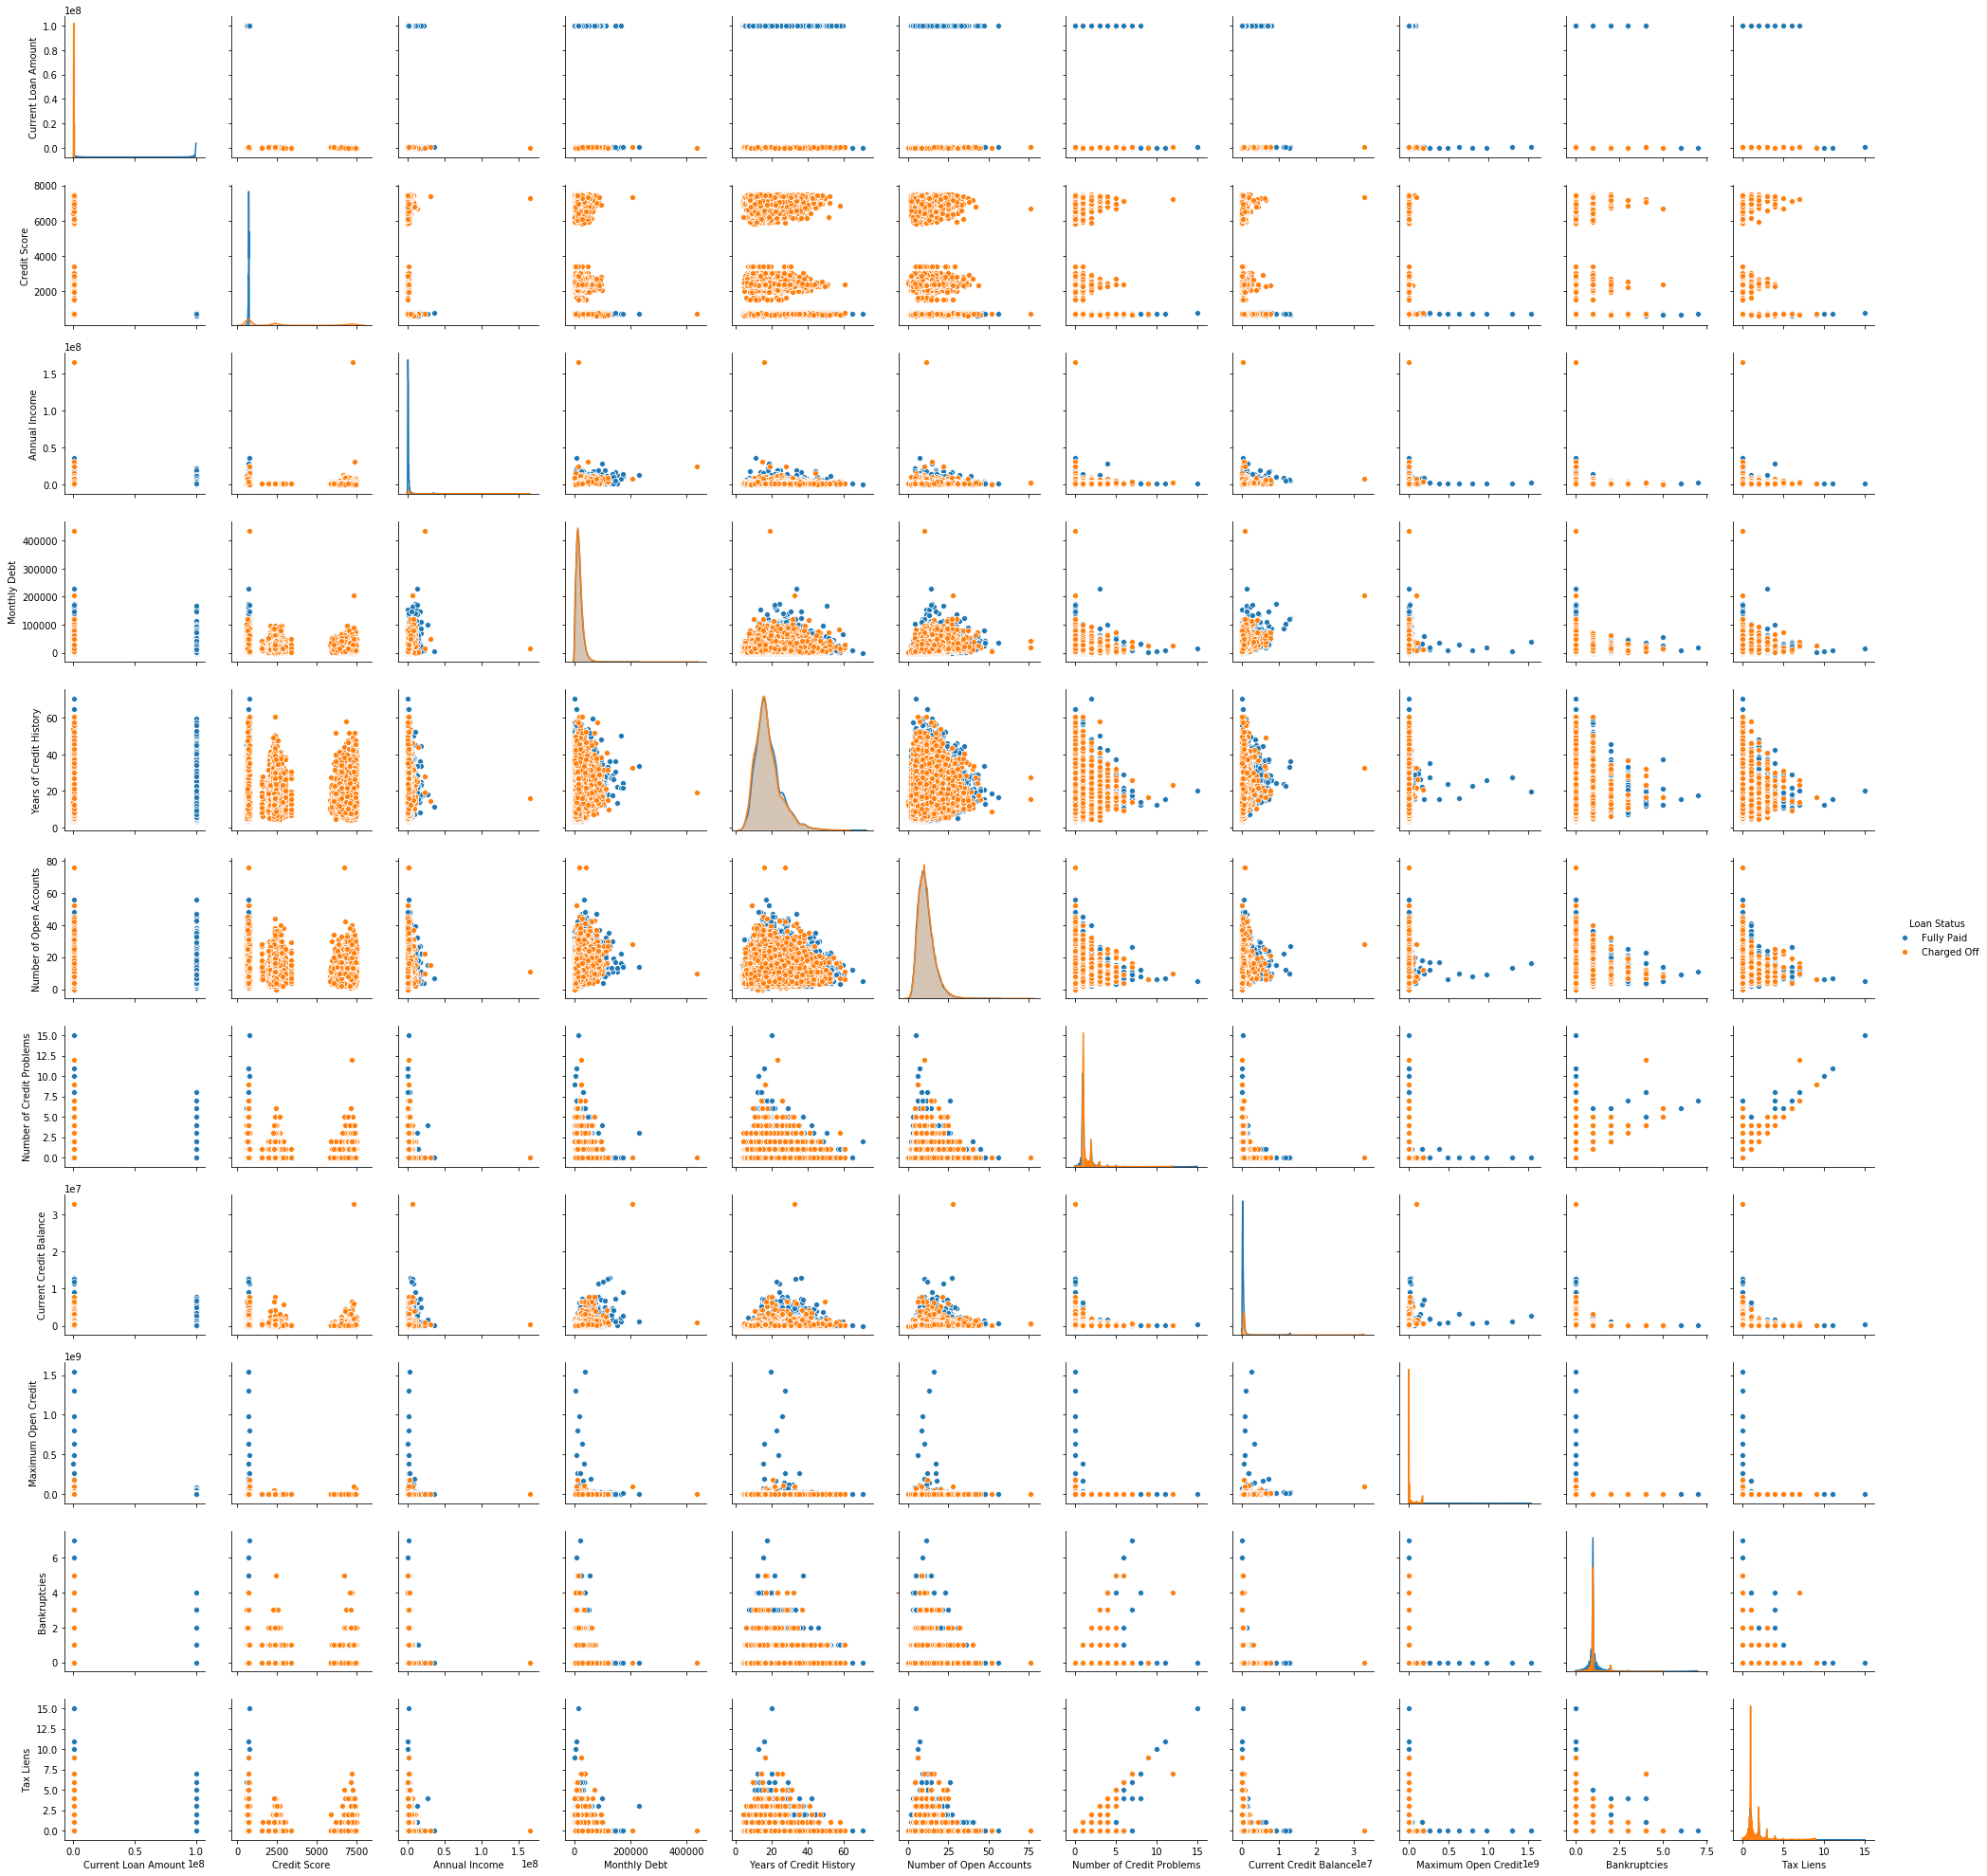

In [15]:
plt.figure(figsize=[20,20])
sns.pairplot(data=df_bank,hue='Loan Status')

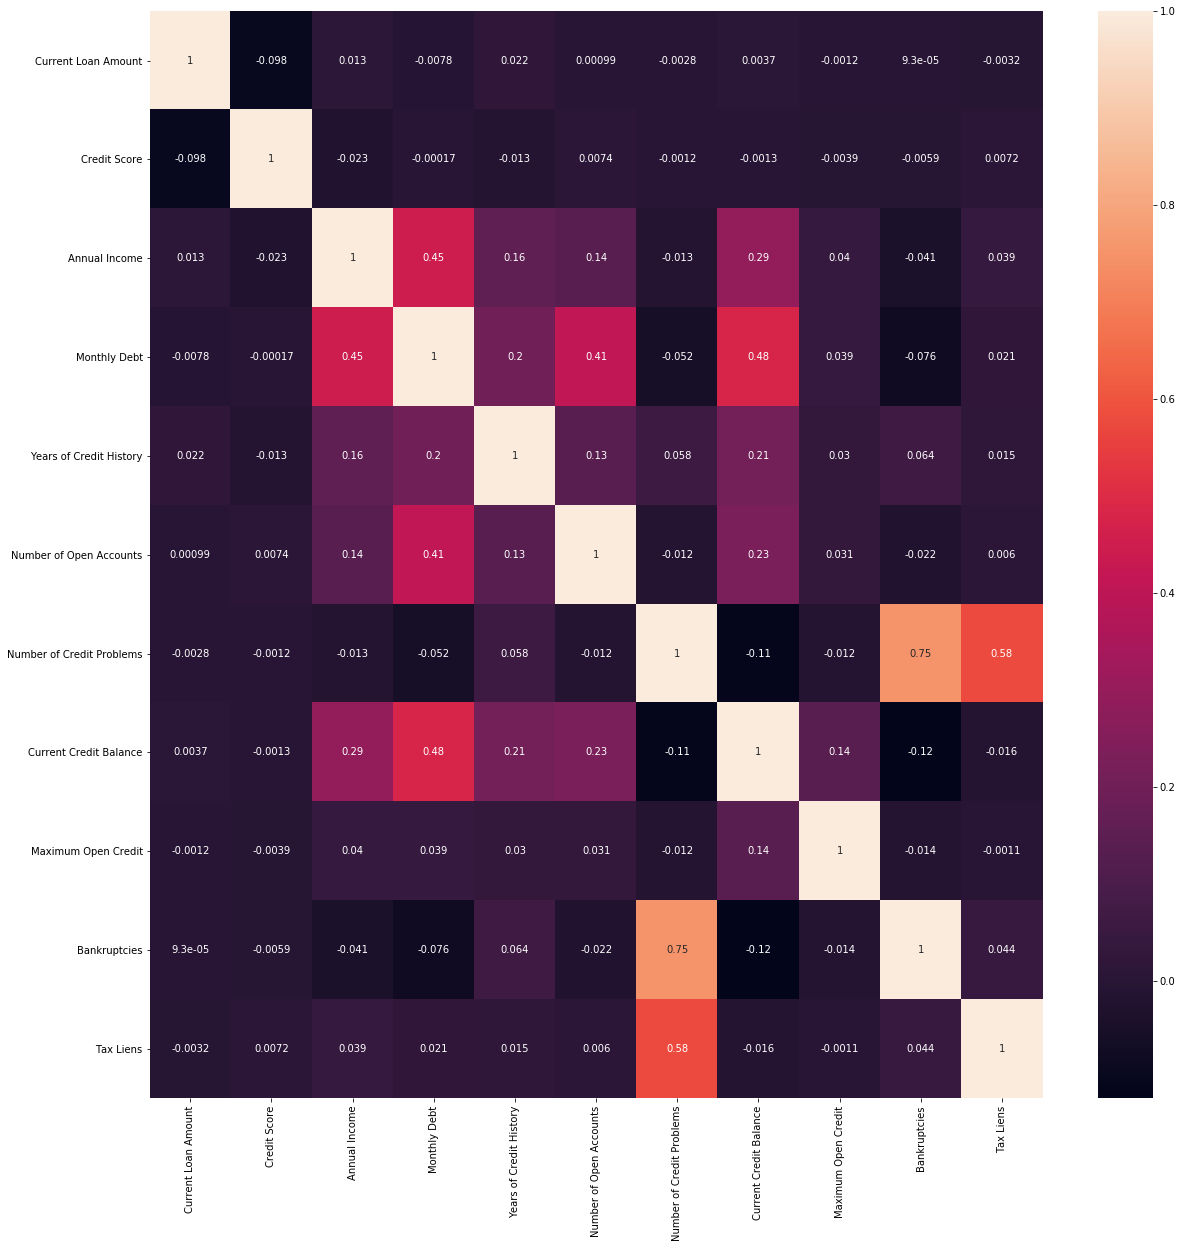

In [16]:
plt.figure(figsize=[20,20])
sns.heatmap(data=df_bank.corr(),annot=True)

In [11]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:,d})'.format(p=pct,v=val)
    return my_autopct

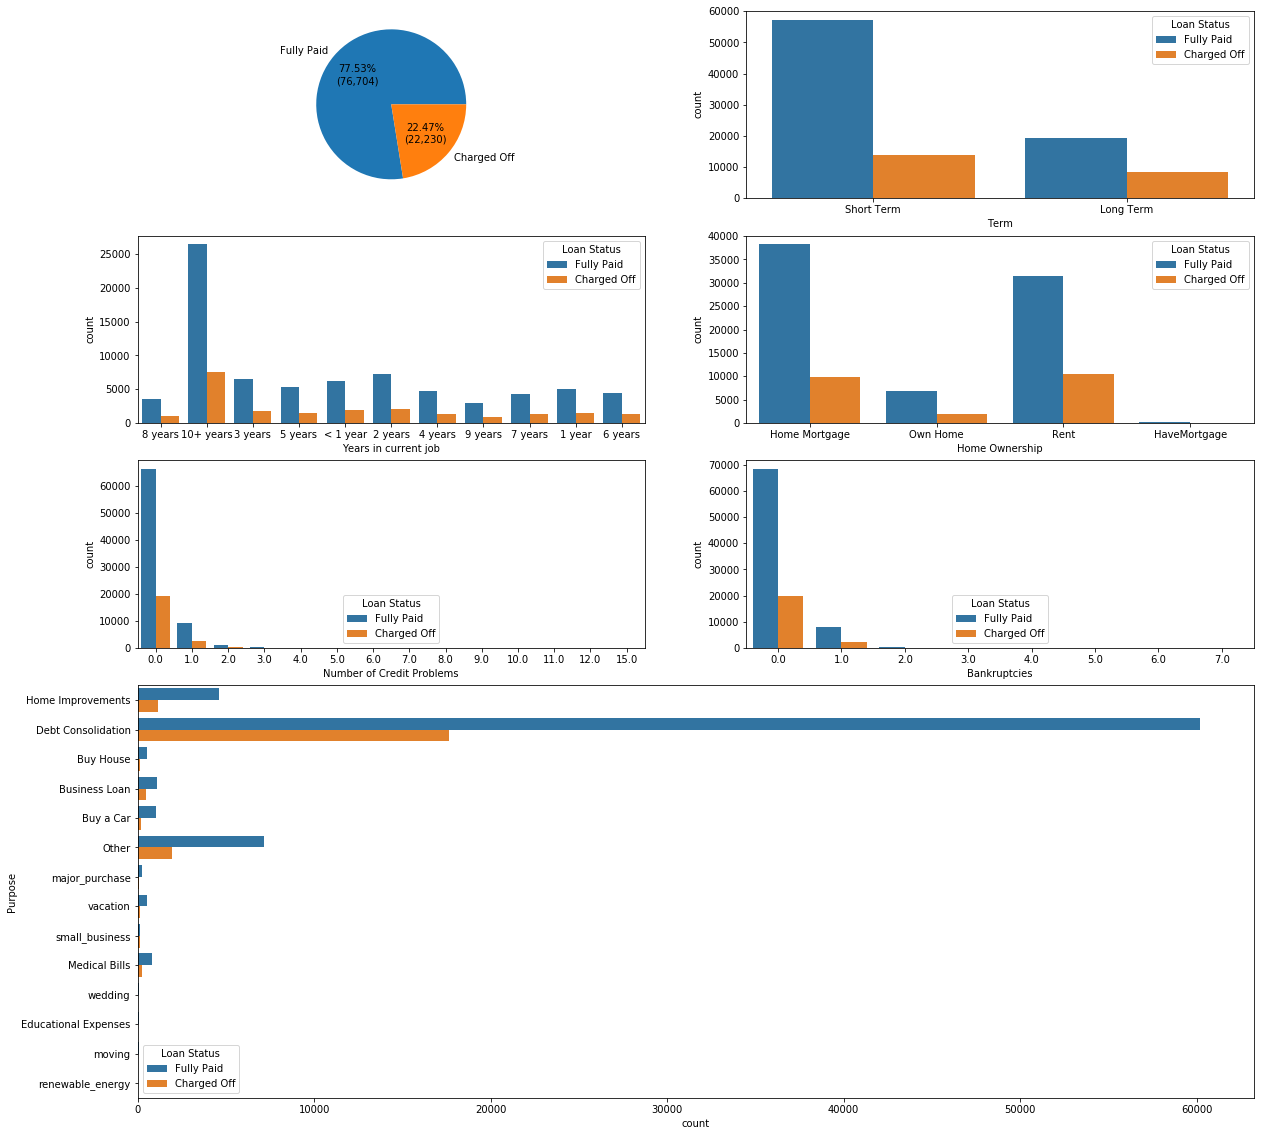

In [31]:
list_kolom=['Loan Status','Term','Years in current job','Home Ownership','Number of Credit Problems',
            'Bankruptcies','Purpose']

baris=0
kolom=1

plt.figure(figsize=(20, 20))
size=((len(list_kolom)//2)+2, 2)
plt.subplot2grid(size, (baris, 0))
plt.pie(df_bank['Loan Status'].value_counts().values,labels=df_bank['Loan Status'].value_counts().index
       ,autopct=make_autopct(df_bank['Loan Status'].value_counts().values))
for fitur in list_kolom[1:-1] :
    plt.subplot2grid(size, (baris, kolom))
    sns.countplot(data=df_bank,x=fitur,hue='Loan Status')
    kolom+=1
    if kolom>1 :
        baris+=1
        kolom=0
plt.subplot2grid(size, (baris, kolom),colspan=2,rowspan=2)
sns.countplot(data=df_bank,y=list_kolom[-1],hue='Loan Status',)
# sns.barplot(data=df_bank,y='Purpose',x='Monthly Debt', hue='Loan Status')
plt.show()
del baris,kolom

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



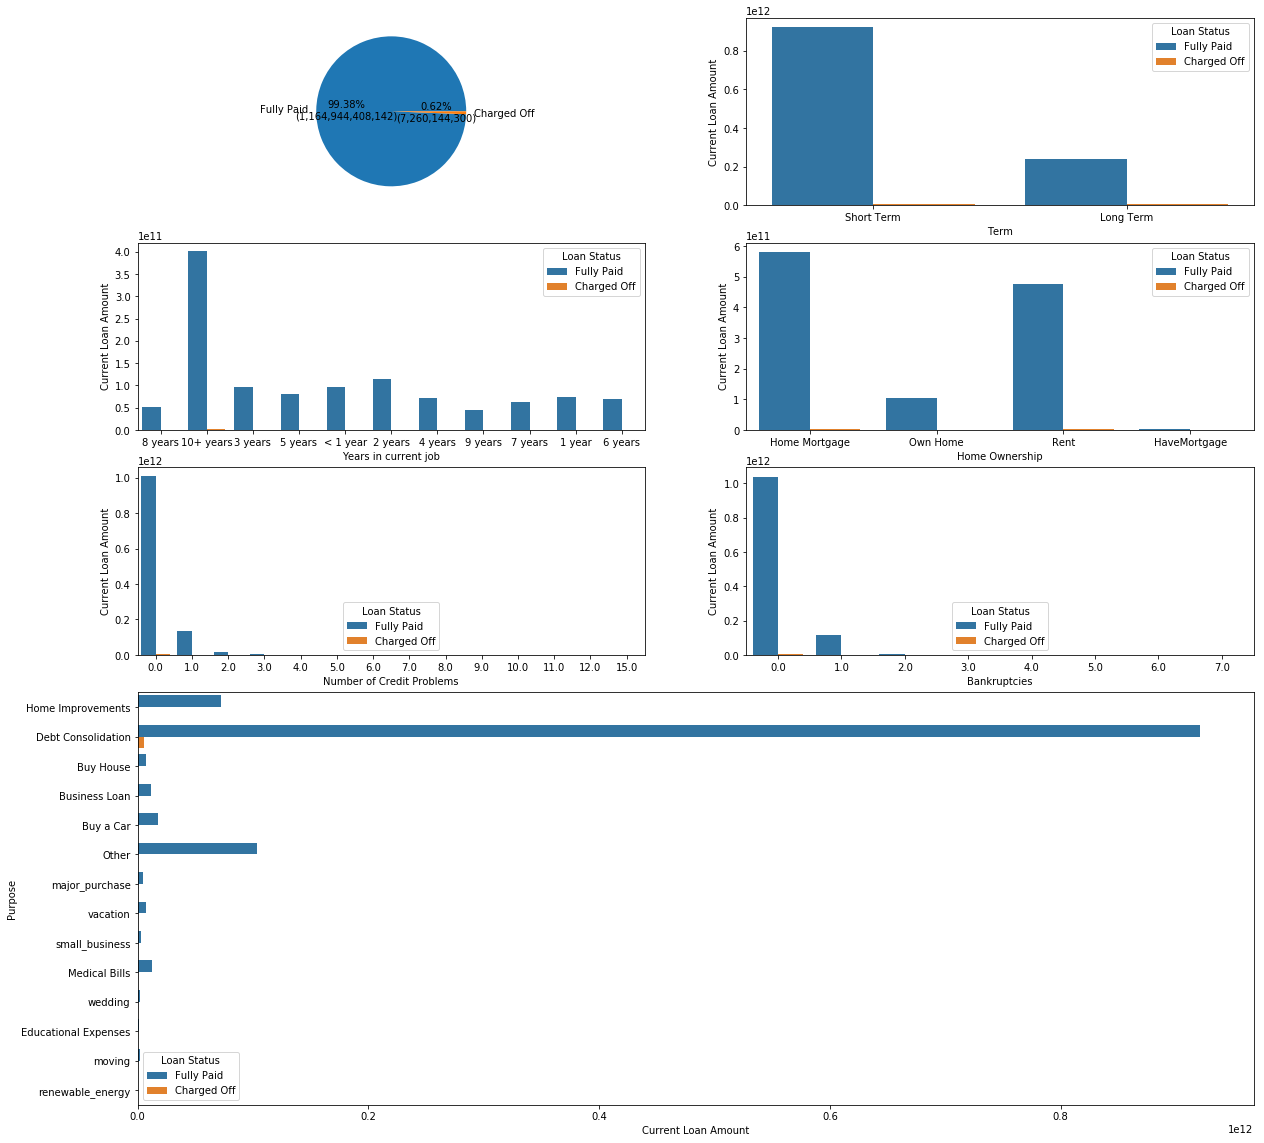

In [32]:
list_kolom=['Loan Status','Term','Years in current job','Home Ownership','Number of Credit Problems',
            'Bankruptcies','Purpose']

baris=0
kolom=1
temp_df=df_bank.groupby('Loan Status',as_index=False).sum().sort_values('Loan Status',ascending=False)[['Loan Status','Current Loan Amount']]

plt.figure(figsize=(20, 20))
size=((len(list_kolom)//2)+2, 2)
plt.subplot2grid(size, (baris, 0))
plt.pie(temp_df['Current Loan Amount'],
        labels=temp_df['Loan Status']
        ,autopct=make_autopct(temp_df['Current Loan Amount']))

for fitur in list_kolom[1:-1] :
    plt.subplot2grid(size, (baris, kolom))
    sns.barplot(data=df_bank,x=fitur ,y='Current Loan Amount',hue='Loan Status',ci=0,estimator=np.sum)
    kolom+=1
    if kolom>1 :
        baris+=1
        kolom=0
plt.subplot2grid(size, (baris, kolom),colspan=2,rowspan=2)
sns.barplot(data=df_bank,y=list_kolom[-1] ,x='Current Loan Amount',hue='Loan Status',ci=0,estimator=np.sum)
# sns.barplot(data=df_bank,y='Purpose',x='Monthly Debt', hue='Loan Status')
plt.show()
del baris,kolom

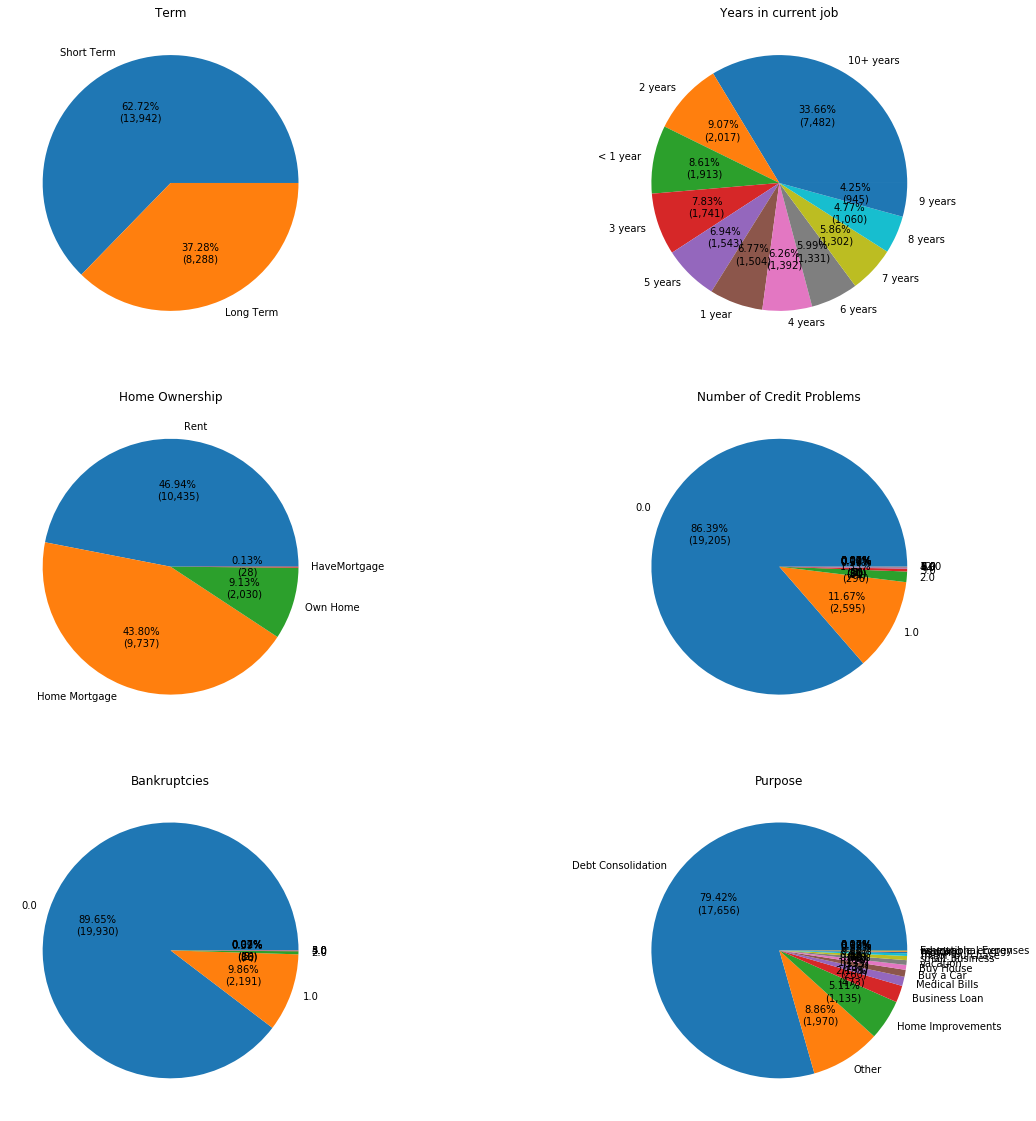

In [41]:
list_kolom=['Term','Years in current job','Home Ownership','Number of Credit Problems',
            'Bankruptcies','Purpose']

baris=0
kolom=0
temp_df=df_bank[df_bank['Loan Status']=='Charged Off']
plt.figure(figsize=(20, 20))
size=((len(list_kolom)//2), 2)

for fitur in list_kolom :
    plt.subplot2grid(size, (baris, kolom))
    plt.title(fitur)
    plt.pie(temp_df[fitur].value_counts().values,labels=temp_df[fitur].value_counts().index
       ,autopct=make_autopct(temp_df[fitur].value_counts().values))
    kolom+=1
    if kolom>1 :
        baris+=1
        kolom=0
        
del baris,kolom,temp_df

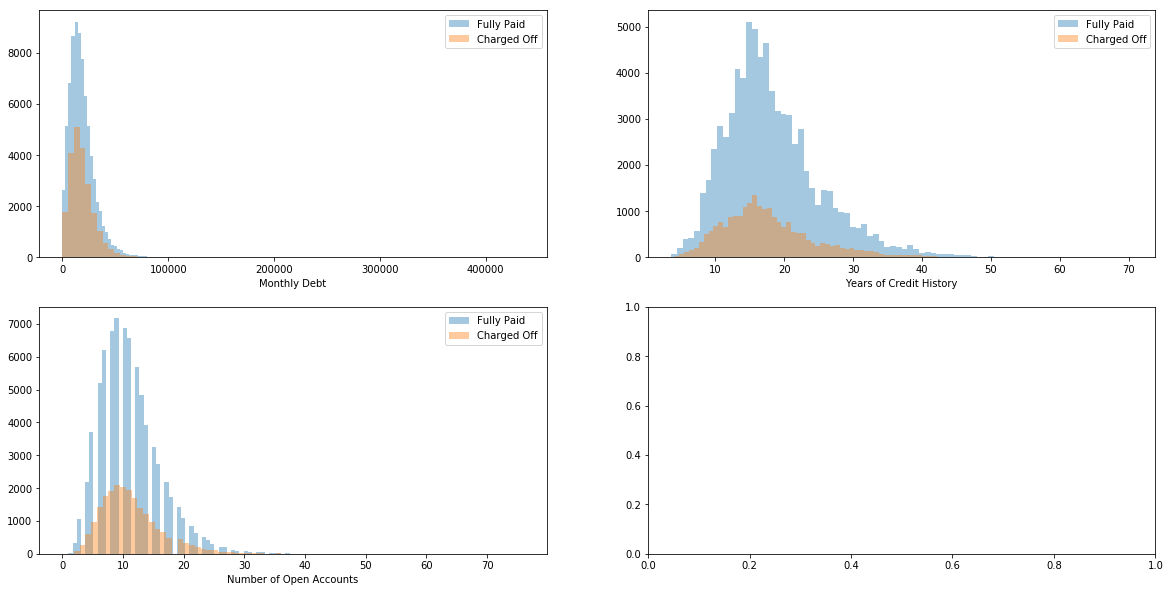

In [113]:
list_kolom=['Monthly Debt','Years of Credit History','Number of Open Accounts']
f, axes = plt.subplots((len(list_kolom)//2)+1, 2, figsize = (20,10))

baris=0
kolom=0
for fitur in list_kolom :
    sns.distplot(df_bank[df_bank['Loan Status']=='Fully Paid'][fitur],kde=False,bins=80, ax=axes[baris,kolom],label='Fully Paid')
    sns.distplot(df_bank[df_bank['Loan Status']=='Charged Off'][fitur],kde=False,bins=80, ax=axes[baris,kolom],label='Charged Off')
    axes[baris,kolom].legend()
    kolom+=1
    if kolom>1 :
        baris+=1
        kolom=0
del baris,kolom

#### DATA PREPARATION

In [46]:
df_for_ML=df_bank.copy()

##### Clamping

In [47]:
batas_atas=df_bank['Annual Income'].mean()+(3*df_bank['Annual Income'].std())
batas_bawah=df_bank['Annual Income'].mean()-(3*df_bank['Annual Income'].std())
df_for_ML=df_for_ML[(df_bank['Annual Income']<=batas_atas)&(df_bank['Annual Income']>=batas_bawah)]

df_for_ML['Annual Income'][df_for_ML['Annual Income']>batas_atas]=batas_atas
df_for_ML['Annual Income'][df_for_ML['Annual Income']<batas_bawah]=batas_bawah

batas_atas=df_bank['Monthly Debt'].mean()+(3*df_bank['Monthly Debt'].std())
batas_bawah=df_bank['Monthly Debt'].mean()-(3*df_bank['Monthly Debt'].std())
df_for_ML=df_for_ML[(df_bank['Monthly Debt']<=batas_atas)&(df_bank['Monthly Debt']>=batas_bawah)]

df_for_ML['Monthly Debt'][df_for_ML['Monthly Debt']>batas_atas]=batas_atas
df_for_ML['Monthly Debt'][df_for_ML['Monthly Debt']<batas_bawah]=batas_bawah

del batas_atas,batas_bawah

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [66]:
df_for_ML['Years in current job']=df_for_ML['Years in current job'].map({'1 year':1,
                                                                     '2 years':2,
                                                                     '3 years':3,
                                                                     '4 years':4,
                                                                     '5 years':5,
                                                                     '6 years':6,
                                                                     '7 years':7,
                                                                     '8 years':8,
                                                                     '9 years':9,
                                                                     '10 years':10,
                                                                     '< 1 year':0,
                                                                     '10+ years':15})

In [67]:
def isi_purpose(purpose):
  if purpose=='Debt Consolidation' : return 1 
  else : return 0
    
labelencoder = LabelEncoder()
df_for_ML['Loan Status'] = labelencoder.fit_transform(df_for_ML['Loan Status'])
df_for_ML['Term'] = labelencoder.fit_transform(df_for_ML['Term'])
df_for_ML['Home Ownership'] = labelencoder.fit_transform(df_for_ML['Home Ownership'])
df_for_ML['Purpose'] = df_for_ML['Purpose'].apply(isi_purpose)

df_for_ML.head()    

Loan ID                           Customer ID  \
0  14dd8831-6af5-400b-83ec-68e61888a048  981165ec-3274-42f5-a3b4-d104041a9ca9   
1  4771cc26-131a-45db-b5aa-537ea4ba5342  2de017a3-2e01-49cb-a581-08169e83be29   
2  4eed4e6a-aa2f-4c91-8651-ce984ee8fb26  5efb2b2b-bf11-4dfd-a572-3761a2694725   
3  77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a  e777faab-98ae-45af-9a86-7ce5b33b1011   
4  d4062e70-befa-4995-8643-a0de73938182  81536ad9-5ccf-4eb8-befb-47a4d608658e   

   Loan Status  Current Loan Amount  Term  Credit Score  Annual Income  \
0            1             445412.0     1         709.0      1167493.0   
1            1             262328.0     1         728.0      1628580.0   
2            1           99999999.0     1         741.0      2231892.0   
3            1             347666.0     0         721.0       806949.0   
4            1             176220.0     1         724.0      1188155.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     8               1        0       5214.74   
1                    15               1        1      33295.98   
2                     8               2        1      29200.53   
3                     3               2        1       8741.90   
4                     5               3        1      20639.70   

   Years of Credit History  Number of Open Accounts  \
0                     17.2                      6.0   
1                     21.1                     35.0   
2                     14.9                     18.0   
3                     12.0                      9.0   
4                      6.1                     15.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        1.0                228190.0             416746.0   
1                        0.0                229976.0             850784.0   
2                        1.0                297996.0             750090.0   
3                        0.0                256329.0             386958.0   
4                        0.0                253460.0             427174.0   

   Bankruptcies  Tax Liens  
0           1.0        0.0  
1           0.0        0.0  
2           0.0        0.0  
3           0.0        0.0  
4           0.0        0.0

In [70]:
df_for_ML.to_csv('datasets/Bank Loan Prediction_readyfit.csv',index=False)

In [44]:
df_for_ML=pd.read_csv('datasets/Bank Loan Prediction_readyfit.csv')

#### MACHINE LEARNING

In [45]:
features = df_for_ML.drop(['Loan Status','Loan ID','Customer ID','Bankruptcies'],axis=1)
target = df_for_ML['Loan Status']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30,random_state=101)

In [46]:
ros = RandomOverSampler(random_state=101)
X_ros,y_ros = ros.fit_sample(X_train,y_train)

X_ros=pd.DataFrame(data=X_ros, columns=X_train.columns)
y_ros=pd.Series(y_ros)
y_ros.value_counts()

1    52609
0    52609
dtype: int64

In [ ]:
Xgboost = XGBClassifier(n_estimators=1000,max_depth=10,n_jobs=-1)
Xgboost.fit(X_ros,y_ros)

In [ ]:
RForest = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
RForest.fit(X_ros,y_ros)

In [42]:
import pickle
Xgboost = pickle.load(open('Models/Xgboost model wCreditScore.sav','rb'))
# RForest = pickle.load(open('C:/Users/Christoforus/Documents/Bank Prediction RForest v2.sav','rb'))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning:

Trying to unpickle estimator LabelEncoder from version 0.20.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.



In [47]:
model_list=[Xgboost]

for alg_model in model_list:
  predictions=alg_model.predict(X_test)
  print('\n\nconfussion matrix:\n',confusion_matrix(y_test,predictions))
  print('\nclasification report:\n', classification_report(y_test,predictions))
  print('Precision:', precision_score(y_test, predictions))
  print('Recall:', recall_score(y_test, predictions))
  print('Accuracy:', accuracy_score(y_test, predictions))
  print('F1 score:', f1_score(y_test, predictions))
  print('Matthews Corrcoef : ', matthews_corrcoef(y_test,predictions))
  print('ROC AUC SCORE : ',roc_auc_score(y_test,predictions))



confussion matrix:
 [[ 3373  3218]
 [  770 21729]]

clasification report:
               precision    recall  f1-score   support

           0       0.81      0.51      0.63      6591
           1       0.87      0.97      0.92     22499

   micro avg       0.86      0.86      0.86     29090
   macro avg       0.84      0.74      0.77     29090
weighted avg       0.86      0.86      0.85     29090

Precision: 0.8710065338517657
Recall: 0.965776256722521
Accuracy: 0.8629082158817463
F1 score: 0.9159465497618344
Matthews Corrcoef :  0.571999412028156
ROC AUC SCORE :  0.7387673576132708


#### TWEAK PROBA

In [4]:
def isi_proba(proba):
  if proba > 0.4 : return 1
  else: return 0

In [77]:
myproba=Xgboost.predict_proba(X_test)[:,1]
myproba=pd.Series(myproba)

predictions_prob=myproba.apply(isi_proba)

In [76]:
print('\n confussion matrix:\n',confusion_matrix(y_test,predictions_prob))
print('\nclasification report:\n', classification_report(y_test,predictions_prob))
print('Precision:', precision_score(y_test, predictions_prob))
print('Recall:', recall_score(y_test, predictions_prob))
print('Accuracy:', accuracy_score(y_test, predictions_prob))
print('F1 score:', f1_score(y_test, predictions_prob))
print('Matthews Corrcoef : ', matthews_corrcoef(y_test,predictions_prob))
print('ROC AUC SCORE : ',roc_auc_score(y_test,predictions_prob))


 confussion matrix:
 [[ 3237  3354]
 [  530 21969]]

clasification report:
               precision    recall  f1-score   support

           0       0.86      0.49      0.63      6591
           1       0.87      0.98      0.92     22499

   micro avg       0.87      0.87      0.87     29090
   macro avg       0.86      0.73      0.77     29090
weighted avg       0.87      0.87      0.85     29090

Precision: 0.8675512380049757
Recall: 0.9764433974843326
Accuracy: 0.8664833276039876
F1 score: 0.9187821504746769
Matthews Corrcoef :  0.5829701781513386
ROC AUC SCORE :  0.7337838289196812
